In [611]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import glob as gb
import cv2
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import VGG16,ResNet50,EfficientNetB0,InceptionV3
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout, GlobalAveragePooling2D
from tensorflow.keras.metrics import AUC, Recall, Precision, SpecificityAtSensitivity, SensitivityAtSpecificity, FalseNegatives, FalsePositives, TrueNegatives, TruePositives,F1Score
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

In [612]:
path='/kaggle/input/plant-d1/D1/'
for folder in  os.listdir(path +'train') : 
    files = gb.glob(pathname= str( path +'train//' + folder + '/*.jpg'))
    print(f'For train data , found {len(files)} in folder {folder}')

For train data , found 52 in folder Class (7)
For train data , found 52 in folder Class (37)


In [613]:
for folder in  os.listdir(path +'test') : 
    files = gb.glob(pathname= str( path +'test//' + folder + '/*.jpg'))
    print(f'For test data , found {len(files)} in folder {folder}')

For test data , found 12 in folder Class (7)
For test data , found 12 in folder Class (37)


In [614]:
#most repeated size in train file
size=[]
for i in os.listdir(path+'train'):
    files=gb.glob(pathname=str(path+'train//'+i+'/*.jpg'))
    for j in files:
        image=cv2.imread(j)
        size.append(image.shape)
pd.Series(size).value_counts()
###############################################

(256, 256, 3)    104
Name: count, dtype: int64

In [615]:
#most repeated size in test file
size=[]
for i in os.listdir(path+'test'):
    files=gb.glob(pathname=str(path+'test//'+i+'/*.jpg'))
    for j in files:
        image=cv2.imread(j)
        size.append(image.shape)
pd.Series(size).value_counts()

(256, 256, 3)    24
Name: count, dtype: int64

In [616]:
# Create a mapping dictionary for class labels
class_mapping = {'Class (37)': 0, 'Class (7)': 1}  # Add more classes as needed
img_size=256

In [617]:
x_train = []  # To store resized images
y_train = []  # To store class labels
for folder in os.listdir(path + 'train'):
    class_label = folder  # Assuming folder names represent class labels
    files = gb.glob(pathname=str(path + 'train//' + folder + '/*.jpg'))
    
    for file in files:
        image = cv2.imread(file)
        resized_image = cv2.resize(image, (img_size, img_size))  # Set your desired width and height
        x_train.append(resized_image)
        y_train.append(class_mapping[class_label])

# Convert the lists to NumPy arrays
x_train = np.array(x_train)
y_train = np.array(y_train)

# Now, x_train contains the resized images, and y_train contains the corresponding numerical class labels (0 and 1)
print(x_train.shape)
print(y_train.shape)

(104, 256, 256, 3)
(104,)


In [618]:
x_test = []  # To store resized images
y_test = []  # To store class labels
for folder in os.listdir(path + 'test'):
    class_label = folder  # Assuming folder names represent class labels
    files = gb.glob(pathname=str(path + 'test//' + folder + '/*.jpg'))
    
    for file in files:
        image = cv2.imread(file)
        resized_image = cv2.resize(image, (img_size, img_size))  # Set your desired width and height
        x_test.append(resized_image)
        y_test.append(class_mapping[class_label])

# Convert the lists to NumPy arrays
x_test = np.array(x_test)
y_test = np.array(y_test)

# Now, x_train contains the resized images, and y_train contains the corresponding numerical class labels (0 and 1)
print(x_test.shape)
print(y_test.shape)

(24, 256, 256, 3)
(24,)


In [619]:
x_train=x_train/255
x_test=x_test/255

In [620]:
augmented_images = []
augmented_labels = []

for i in range(len(x_train)):
    img = x_train[i]

    # Append original image
    augmented_images.append(img)
    augmented_labels.append(y_train[i])

    # Apply vertical flip
    img_vertical_flip = cv2.flip(img, 0)
    augmented_images.append(img_vertical_flip)
    augmented_labels.append(y_train[i])

    # Apply horizontal flip
    img_horizontal_flip = cv2.flip(img, 1)
    augmented_images.append(img_horizontal_flip)
    augmented_labels.append(y_train[i])

    # Apply mirror transformation
    img_mirror = cv2.flip(img, -1)
    augmented_images.append(img_mirror)
    augmented_labels.append(y_train[i])

# Convert the augmented images and labels to NumPy arrays
x_train = np.array(augmented_images)
y_train = np.array(augmented_labels)

# Print the shapes to verify
print(x_train.shape)
print(y_train.shape)


(416, 256, 256, 3)
(416,)


In [621]:

    # Applying data augmentation to x_test
    augmented_images_test = []
    augmented_labels_test = []

    for i in range(len(x_test)):
        img = x_test[i]

        # Append original image
        augmented_images_test.append(img)
        augmented_labels_test.append(y_test[i])

        # Apply vertical flip
        img_vertical_flip = cv2.flip(img, 0)
        augmented_images_test.append(img_vertical_flip)
        augmented_labels_test.append(y_test[i])

        # Apply horizontal flip
        img_horizontal_flip = cv2.flip(img, 1)
        augmented_images_test.append(img_horizontal_flip)
        augmented_labels_test.append(y_test[i])

        # Apply mirror transformation
        img_mirror = cv2.flip(img, -1)
        augmented_images_test.append(img_mirror)
        augmented_labels_test.append(y_test[i])

    # Convert the augmented test images and labels to NumPy arrays
    x_test = np.array(augmented_images_test)
    y_test = np.array(augmented_labels_test)

    # Print the shapes to verify
    print(x_test.shape)
    print(y_test.shape)


(96, 256, 256, 3)
(96,)


In [622]:
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.2, random_state=42)
print(x_valid.shape)
print(y_valid.shape)

(84, 256, 256, 3)
(84,)


In [623]:
# Create a VGG16 model with pre-trained weights on ImageNet
pretrained_model_vgg16 = VGG16(include_top=False,
                        input_shape=(img_size, img_size, 3),
                        pooling='avg',
                        weights='imagenet')

# Freeze the layers of the pre-trained model
for layer in pretrained_model_vgg16.layers:
    layer.trainable = False

# Create a Sequential model
vgg16_model = Sequential()

# Add the VGG16 pre-trained model to your Sequential model
vgg16_model.add(pretrained_model)

# Flatten layer
vgg16_model.add(Flatten())

# Dense layers
vgg16_model.add(Dense(128, activation='relu'))
vgg16_model.add(Dropout(0.5))
vgg16_model.add(Dense(128, activation='relu'))
vgg16_model.add(Dropout(0.5))
vgg16_model.add(Dense(1, activation='sigmoid'))

# Display model summary
print("VGG16 Model Summary:")
vgg16_model.summary()

VGG16 Model Summary:
Model: "sequential_142"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 512)               14714688  
                                                                 
 flatten_37 (Flatten)        (None, 512)               0         
                                                                 
 dense_296 (Dense)           (None, 128)               65664     
                                                                 
 dropout_50 (Dropout)        (None, 128)               0         
                                                                 
 dense_297 (Dense)           (None, 128)               16512     
                                                                 
 dropout_51 (Dropout)        (None, 128)               0         
                                                                 
 dense_298 (Dense)           (N

In [624]:
#compile model
vgg16_model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy',  
                             AUC(),
                             Recall(),
                             Precision(),
                             SpecificityAtSensitivity(0.5),
                             SensitivityAtSpecificity(0.5),
                             FalseNegatives(),
                             FalsePositives(),
                             TrueNegatives(),
                             TruePositives()])
#########################################
#train model
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
vgg16_model.fit(x_train,y_train, batch_size=32,epochs = 100, validation_data = (x_valid,y_valid),callbacks=[early_stopping])

Epoch 1/100
11/11 [==============================] - 4s 190ms/step - loss: 0.6835 - accuracy: 0.6024 - auc_117: 0.6248 - recall_116: 0.5663 - precision_117: 0.6104 - specificity_at_sensitivity_114: 0.6807 - sensitivity_at_specificity_113: 0.6325 - false_negatives_113: 72.0000 - false_positives_113: 60.0000 - true_negatives_113: 106.0000 - true_positives_113: 94.0000 - val_loss: 295.1204 - val_accuracy: 0.8929 - val_auc_117: 0.8367 - val_recall_116: 1.0000 - val_precision_117: 0.8235 - val_specificity_at_sensitivity_114: 0.8095 - val_sensitivity_at_specificity_113: 1.0000 - val_false_negatives_113: 0.0000e+00 - val_false_positives_113: 9.0000 - val_true_negatives_113: 33.0000 - val_true_positives_113: 42.0000
Epoch 2/100
11/11 [==============================] - 1s 109ms/step - loss: 0.5656 - accuracy: 0.7229 - auc_117: 0.8268 - recall_116: 0.8976 - precision_117: 0.6652 - specificity_at_sensitivity_114: 0.9036 - sensitivity_at_specificity_113: 0.9277 - false_negatives_113: 17.0000 - fal

In [625]:
results_vgg16 = vgg16_model.evaluate(x_test, y_test, verbose=1)

# This will print the evaluation results (loss, accuracy, and other metrics specified during model compilation)
print("Test Loss:", results_vgg16[0])
print("Test Accuracy:", results_vgg16[1])
# You can print other metrics based on your model's configuration

#test the model
predictions_vgg16 = vgg16_model.predict(x_test)

3/3 [==============================] - 0s 90ms/step - loss: 0.0300 - accuracy: 1.0000 - auc_117: 1.0000 - recall_116: 1.0000 - precision_117: 1.0000 - specificity_at_sensitivity_114: 1.0000 - sensitivity_at_specificity_113: 1.0000 - false_negatives_113: 0.0000e+00 - false_positives_113: 0.0000e+00 - true_negatives_113: 48.0000 - true_positives_113: 48.0000        
Test Loss: 0.030029824003577232
Test Accuracy: 1.0
3/3 [==============================] - 0s 78ms/step


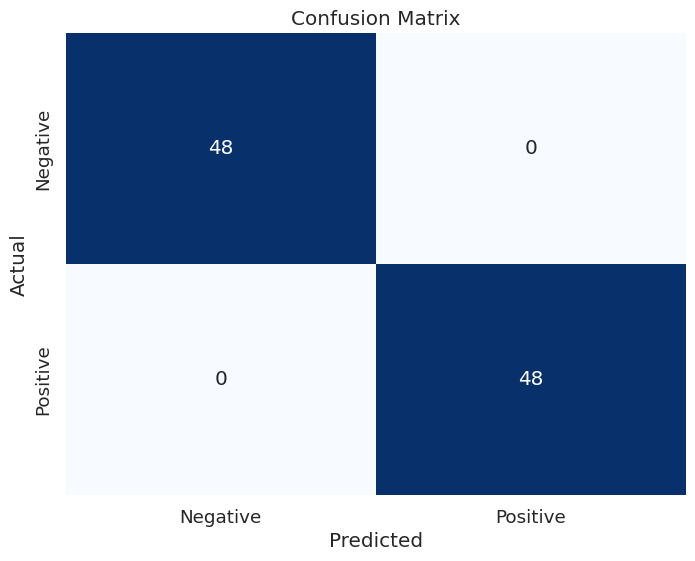

F1 Score: 1.0
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        48
           1       1.00      1.00      1.00        48

    accuracy                           1.00        96
   macro avg       1.00      1.00      1.00        96
weighted avg       1.00      1.00      1.00        96



In [626]:
# Convert probabilities to binary predictions (assuming a threshold of 0.5)
binary_predictions_vgg16 = (predictions_vgg16 > 0.5).astype(int)

# Create confusion matrix
conf_matrix = confusion_matrix(y_test, binary_predictions_vgg16)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Adjust font size for better readability
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Calculate F1 score
f1_vgg16 = f1_score(y_test, binary_predictions_vgg16)

# Print F1 score
print("F1 Score:", f1_vgg16)

# Print detailed classification report
print("Classification Report:")
print(classification_report(y_test, binary_predictions_vgg16))

In [627]:
# Create a resnet50 model with pre-trained weights on ImageNet
pretrained_model_resnet50 = ResNet50(include_top=False,
                        input_shape=(img_size, img_size, 3),
                        pooling='avg',
                        weights='imagenet')

# Freeze the layers of the pre-trained model
for layer in pretrained_model_resnet50.layers:
    layer.trainable = False

# Create a Sequential model
resnet50_model = Sequential()

# Add the resnet50 pre-trained model to your Sequential model
resnet50_model.add(pretrained_model)

# Flatten layer
resnet50_model.add(Flatten())

# Dense layers
resnet50_model.add(Dense(128, activation='relu'))
resnet50_model.add(Dropout(0.5))
resnet50_model.add(Dense(128, activation='relu'))
resnet50_model.add(Dropout(0.5))
resnet50_model.add(Dense(1, activation='sigmoid'))

# Display model summary
print("resnet50 Model Summary:")
resnet50_model.summary()

resnet50 Model Summary:
Model: "sequential_143"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 512)               14714688  
                                                                 
 flatten_38 (Flatten)        (None, 512)               0         
                                                                 
 dense_299 (Dense)           (None, 128)               65664     
                                                                 
 dropout_52 (Dropout)        (None, 128)               0         
                                                                 
 dense_300 (Dense)           (None, 128)               16512     
                                                                 
 dropout_53 (Dropout)        (None, 128)               0         
                                                                 
 dense_301 (Dense)          

In [628]:
#compile model
resnet50_model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy',  
                             AUC(),
                             Recall(),
                             Precision(),
                             SpecificityAtSensitivity(0.5),
                             SensitivityAtSpecificity(0.5),
                             FalseNegatives(),
                             FalsePositives(),
                             TrueNegatives(),
                             TruePositives()])
#########################################
#train model
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
resnet50_model.fit(x_train,y_train, batch_size=32,epochs = 100, validation_data = (x_valid,y_valid),callbacks=[early_stopping])

Epoch 1/100
11/11 [==============================] - 4s 191ms/step - loss: 0.6737 - accuracy: 0.6446 - auc_118: 0.6679 - recall_117: 0.6446 - precision_118: 0.6446 - specificity_at_sensitivity_115: 0.7470 - sensitivity_at_specificity_114: 0.8012 - false_negatives_114: 59.0000 - false_positives_114: 59.0000 - true_negatives_114: 107.0000 - true_positives_114: 107.0000 - val_loss: 201.8070 - val_accuracy: 0.8095 - val_auc_118: 0.8367 - val_recall_117: 1.0000 - val_precision_118: 0.7241 - val_specificity_at_sensitivity_115: 0.8095 - val_sensitivity_at_specificity_114: 1.0000 - val_false_negatives_114: 0.0000e+00 - val_false_positives_114: 16.0000 - val_true_negatives_114: 26.0000 - val_true_positives_114: 42.0000
Epoch 2/100
11/11 [==============================] - 1s 108ms/step - loss: 0.5483 - accuracy: 0.7380 - auc_118: 0.8066 - recall_117: 0.7952 - precision_118: 0.7135 - specificity_at_sensitivity_115: 0.8735 - sensitivity_at_specificity_114: 0.9036 - false_negatives_114: 34.0000 - f

In [629]:
results_resnet50 = resnet50_model.evaluate(x_test, y_test, verbose=1)

# This will print the evaluation results (loss, accuracy, and other metrics specified during model compilation)
print("Test Loss:", results_resnet50[0])
print("Test Accuracy:", results_resnet50[1])
# You can print other metrics based on your model's configuration

#test the model
predictions_resnet50 = resnet50_model.predict(x_test)

3/3 [==============================] - 0s 91ms/step - loss: 0.0390 - accuracy: 1.0000 - auc_118: 1.0000 - recall_117: 1.0000 - precision_118: 1.0000 - specificity_at_sensitivity_115: 1.0000 - sensitivity_at_specificity_114: 1.0000 - false_negatives_114: 0.0000e+00 - false_positives_114: 0.0000e+00 - true_negatives_114: 48.0000 - true_positives_114: 48.0000        
Test Loss: 0.039000656455755234
Test Accuracy: 1.0
3/3 [==============================] - 0s 78ms/step


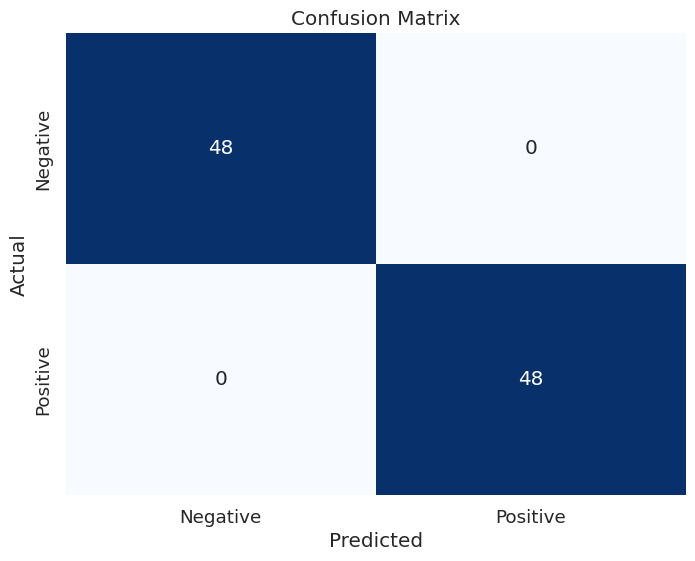

F1 Score: 1.0
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        48
           1       1.00      1.00      1.00        48

    accuracy                           1.00        96
   macro avg       1.00      1.00      1.00        96
weighted avg       1.00      1.00      1.00        96



In [630]:
# Convert probabilities to binary predictions (assuming a threshold of 0.5)
binary_predictions_resnet50 = (predictions_resnet50 > 0.5).astype(int)

# Create confusion matrix
conf_matrix = confusion_matrix(y_test, binary_predictions_resnet50)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Adjust font size for better readability
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Calculate F1 score
f1_resnet50 = f1_score(y_test, binary_predictions_resnet50)

# Print F1 score
print("F1 Score:", f1_resnet50)

# Print detailed classification report
print("Classification Report:")
print(classification_report(y_test, binary_predictions_resnet50))

In [631]:
# Create a EfficientNetB0 model with pre-trained weights on ImageNet
pretrained_model_EfficientNetB0 = EfficientNetB0(include_top=False,
                        input_shape=(img_size, img_size, 3),
                        pooling='avg',
                        weights='imagenet')

# Freeze the layers of the pre-trained model
for layer in pretrained_model_EfficientNetB0.layers:
    layer.trainable = False

# Create a Sequential model
EfficientNetB0_model = Sequential()

# Add the EfficientNetB0 pre-trained model to your Sequential model
EfficientNetB0_model.add(pretrained_model)

# Flatten layer
EfficientNetB0_model.add(Flatten())

# Dense layers
EfficientNetB0_model.add(Dense(128, activation='relu'))
EfficientNetB0_model.add(Dropout(0.5))
EfficientNetB0_model.add(Dense(128, activation='relu'))
EfficientNetB0_model.add(Dropout(0.5))
EfficientNetB0_model.add(Dense(1, activation='sigmoid'))

# Display model summary
print("EfficientNetB0 Model Summary:")
EfficientNetB0_model.summary()


EfficientNetB0 Model Summary:
Model: "sequential_144"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 512)               14714688  
                                                                 
 flatten_39 (Flatten)        (None, 512)               0         
                                                                 
 dense_302 (Dense)           (None, 128)               65664     
                                                                 
 dropout_54 (Dropout)        (None, 128)               0         
                                                                 
 dense_303 (Dense)           (None, 128)               16512     
                                                                 
 dropout_55 (Dropout)        (None, 128)               0         
                                                                 
 dense_304 (Dense)    

In [632]:
EfficientNetB0_model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy',  
                             AUC(),
                             Recall(),
                             Precision(),
                             SpecificityAtSensitivity(0.5),
                             SensitivityAtSpecificity(0.5),
                             FalseNegatives(),
                             FalsePositives(),
                             TrueNegatives(),
                             TruePositives()])
#########################################
#train model
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
EfficientNetB0_model.fit(x_train,y_train, batch_size=32,epochs = 100, validation_data = (x_valid,y_valid),callbacks=[early_stopping])

Epoch 1/100
11/11 [==============================] - 4s 189ms/step - loss: 0.7520 - accuracy: 0.5843 - auc_119: 0.5835 - recall_118: 0.5422 - precision_119: 0.5921 - specificity_at_sensitivity_116: 0.6506 - sensitivity_at_specificity_115: 0.6747 - false_negatives_115: 76.0000 - false_positives_115: 62.0000 - true_negatives_115: 104.0000 - true_positives_115: 90.0000 - val_loss: 163.0905 - val_accuracy: 0.8214 - val_auc_119: 0.8367 - val_recall_118: 1.0000 - val_precision_119: 0.7368 - val_specificity_at_sensitivity_116: 0.8095 - val_sensitivity_at_specificity_115: 1.0000 - val_false_negatives_115: 0.0000e+00 - val_false_positives_115: 15.0000 - val_true_negatives_115: 27.0000 - val_true_positives_115: 42.0000
Epoch 2/100
11/11 [==============================] - 1s 109ms/step - loss: 0.5719 - accuracy: 0.7590 - auc_119: 0.8363 - recall_118: 0.8072 - precision_119: 0.7363 - specificity_at_sensitivity_116: 0.9036 - sensitivity_at_specificity_115: 0.9518 - false_negatives_115: 32.0000 - fa

In [633]:
results_EfficientNetB0 = EfficientNetB0_model.evaluate(x_test, y_test, verbose=1)

# This will print the evaluation results (loss, accuracy, and other metrics specified during model compilation)
print("Test Loss:", results_EfficientNetB0[0])
print("Test Accuracy:", results_EfficientNetB0[1])
# You can print other metrics based on your model's configuration

#test the model
predictions_EfficientNetB0 = EfficientNetB0_model.predict(x_test)

3/3 [==============================] - 0s 91ms/step - loss: 0.0137 - accuracy: 1.0000 - auc_119: 1.0000 - recall_118: 1.0000 - precision_119: 1.0000 - specificity_at_sensitivity_116: 1.0000 - sensitivity_at_specificity_115: 1.0000 - false_negatives_115: 0.0000e+00 - false_positives_115: 0.0000e+00 - true_negatives_115: 48.0000 - true_positives_115: 48.0000        
Test Loss: 0.013668832369148731
Test Accuracy: 1.0
3/3 [==============================] - 0s 79ms/step


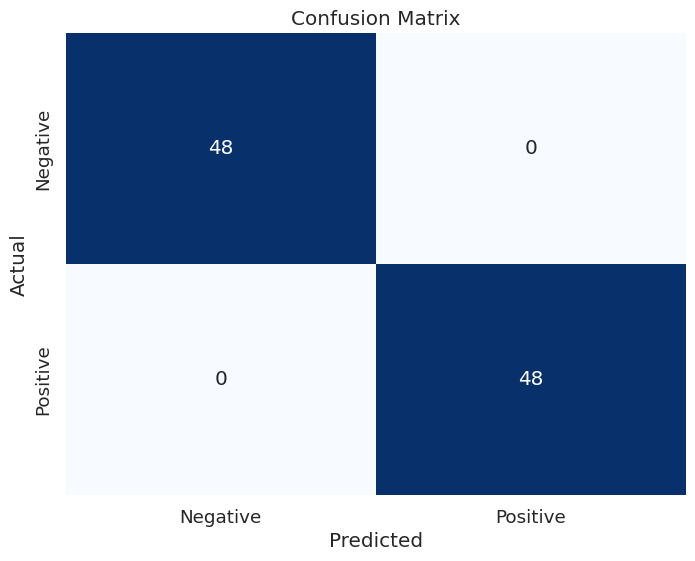

F1 Score: 1.0
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        48
           1       1.00      1.00      1.00        48

    accuracy                           1.00        96
   macro avg       1.00      1.00      1.00        96
weighted avg       1.00      1.00      1.00        96



In [634]:
# Convert probabilities to binary predictions (assuming a threshold of 0.5)
binary_predictions_EfficientNetB0 = (predictions_EfficientNetB0 > 0.5).astype(int)

# Create confusion matrix
conf_matrix = confusion_matrix(y_test, binary_predictions_EfficientNetB0)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Adjust font size for better readability
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Calculate F1 score
f1_EfficientNetB0 = f1_score(y_test, binary_predictions_EfficientNetB0)

# Print F1 score
print("F1 Score:", f1_EfficientNetB0)

# Print detailed classification report
print("Classification Report:")
print(classification_report(y_test, binary_predictions_EfficientNetB0))

In [635]:
# Create a inceptionv3 model with pre-trained weights on ImageNet
pretrained_model_inceptionv3 = InceptionV3(include_top=False,
                        input_shape=(img_size, img_size, 3),
                        pooling='avg',
                        weights='imagenet')

# Freeze the layers of the pre-trained model
for layer in pretrained_model_inceptionv3.layers:
    layer.trainable = False

# Create a Sequential model
inceptionv3_model = Sequential()

# Add the inceptionv3 pre-trained model to your Sequential model
inceptionv3_model.add(pretrained_model)

# Flatten layer
inceptionv3_model.add(Flatten())

# Dense layers
inceptionv3_model.add(Dense(128, activation='relu'))
inceptionv3_model.add(Dropout(0.5))
inceptionv3_model.add(Dense(128, activation='relu'))
inceptionv3_model.add(Dropout(0.5))
inceptionv3_model.add(Dense(1, activation='sigmoid'))

# Display model summary
print("inceptionv3 Model Summary:")
inceptionv3_model.summary()

inceptionv3 Model Summary:
Model: "sequential_145"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 512)               14714688  
                                                                 
 flatten_40 (Flatten)        (None, 512)               0         
                                                                 
 dense_305 (Dense)           (None, 128)               65664     
                                                                 
 dropout_56 (Dropout)        (None, 128)               0         
                                                                 
 dense_306 (Dense)           (None, 128)               16512     
                                                                 
 dropout_57 (Dropout)        (None, 128)               0         
                                                                 
 dense_307 (Dense)       

In [636]:
#compile model
inceptionv3_model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy',  
                             AUC(),
                             Recall(),
                             Precision(),
                             SpecificityAtSensitivity(0.5),
                             SensitivityAtSpecificity(0.5),
                             FalseNegatives(),
                             FalsePositives(),
                             TrueNegatives(),
                             TruePositives()])
#########################################
#train model
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
inceptionv3_model.fit(x_train,y_train, batch_size=32,epochs = 100, validation_data = (x_valid,y_valid),callbacks=[early_stopping])

Epoch 1/100
11/11 [==============================] - 4s 189ms/step - loss: 0.7982 - accuracy: 0.5181 - auc_120: 0.5099 - recall_119: 0.4880 - precision_120: 0.5192 - specificity_at_sensitivity_117: 0.5361 - sensitivity_at_specificity_116: 0.5361 - false_negatives_116: 85.0000 - false_positives_116: 75.0000 - true_negatives_116: 91.0000 - true_positives_116: 81.0000 - val_loss: 188.2251 - val_accuracy: 0.6548 - val_auc_120: 0.8367 - val_recall_119: 1.0000 - val_precision_120: 0.5915 - val_specificity_at_sensitivity_117: 0.8095 - val_sensitivity_at_specificity_116: 1.0000 - val_false_negatives_116: 0.0000e+00 - val_false_positives_116: 29.0000 - val_true_negatives_116: 13.0000 - val_true_positives_116: 42.0000
Epoch 2/100
11/11 [==============================] - 1s 107ms/step - loss: 0.5950 - accuracy: 0.7139 - auc_120: 0.7719 - recall_119: 0.8373 - precision_120: 0.6715 - specificity_at_sensitivity_117: 0.8133 - sensitivity_at_specificity_116: 0.8795 - false_negatives_116: 27.0000 - fal

In [637]:
results_inceptionv3 = inceptionv3_model.evaluate(x_test, y_test, verbose=1)

# This will print the evaluation results (loss, accuracy, and other metrics specified during model compilation)
print("Test Loss:", results_inceptionv3[0])
print("Test Accuracy:", results_inceptionv3[1])
# You can print other metrics based on your model's configuration

#test the model
predictions_inceptionv3 = inceptionv3_model.predict(x_test)

3/3 [==============================] - 0s 92ms/step - loss: 0.0553 - accuracy: 1.0000 - auc_120: 1.0000 - recall_119: 1.0000 - precision_120: 1.0000 - specificity_at_sensitivity_117: 1.0000 - sensitivity_at_specificity_116: 1.0000 - false_negatives_116: 0.0000e+00 - false_positives_116: 0.0000e+00 - true_negatives_116: 48.0000 - true_positives_116: 48.0000        
Test Loss: 0.055347148329019547
Test Accuracy: 1.0
3/3 [==============================] - 0s 78ms/step


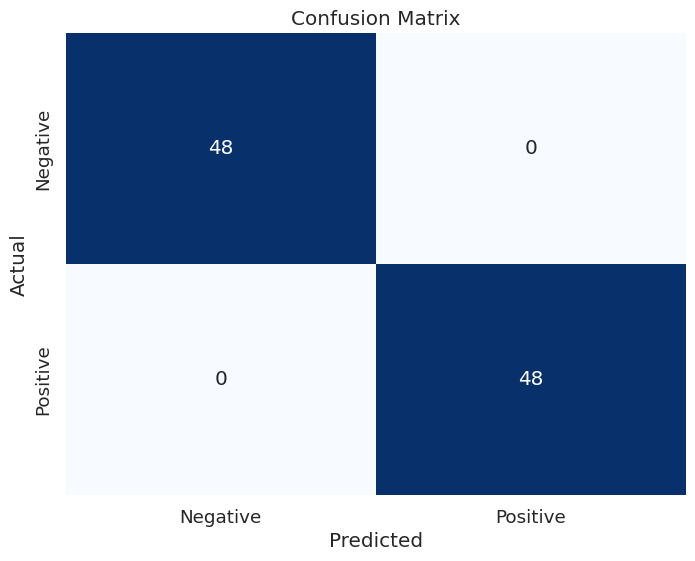

F1 Score: 1.0
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        48
           1       1.00      1.00      1.00        48

    accuracy                           1.00        96
   macro avg       1.00      1.00      1.00        96
weighted avg       1.00      1.00      1.00        96



In [638]:
# Convert probabilities to binary predictions (assuming a threshold of 0.5)
binary_predictions_inceptionv3 = (predictions_inceptionv3 > 0.5).astype(int)

# Create confusion matrix
conf_matrix = confusion_matrix(y_test, binary_predictions_inceptionv3)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Adjust font size for better readability
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Calculate F1 score
f1_inceptionv3 = f1_score(y_test, binary_predictions_inceptionv3)

# Print F1 score
print("F1 Score:", f1_inceptionv3)

# Print detailed classification report
print("Classification Report:")
print(classification_report(y_test, binary_predictions_inceptionv3))